Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

In [23]:
from category_encoders import OrdinalEncoder
from numpy.random import permutation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Boosting and Permutation Importance

- Use xgboost for **gradient boosting**
- Get **permutation importances** for model interpretation and feature selection

# I. Wrangle Data

## Import

In [3]:
# Merge train_features.csv & train_labels.csv
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

## Wrangle Function

In [4]:
def wrangle(X):
    # Make a copy
    X = X.copy()

    # Drop high cardinality cols
    high_card_cols = [col for col in X.select_dtypes('object').columns
                      if X[col].nunique() > 100]

    X.drop(columns=high_card_cols, inplace=True)

    # Drop repeated columns
    cols = ['extraction_type_group', 'quantity']
    X.drop(columns=cols, inplace=True)

    return X

In [5]:
df = wrangle(df)

In [6]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,...,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# II. Split Data

In [7]:
# Split our feature matrix and target vector
y = df['status_group']
X = df.drop('status_group', axis=1)

In [8]:
# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

In [9]:
print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Model

In [10]:
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train, y_train);

In [11]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,
                  n_jobs=10)
)

model_xgb.fit(X_train, y_train);

# Check Metrics

In [12]:
print('sklearn Training Accuracy:', model_skgb.score(X_train, y_train))
print('sklearn Validation Accuracy:', model_skgb.score(X_val, y_val))

sklearn Training Accuracy: 0.7505629327216482
sklearn Validation Accuracy: 0.7522727272727273


In [13]:
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.8408636545381847
XGBoost Validation Accuracy: 0.7988215488215489


# Communicate Results

- How can we determine or communicate which features are most important to our model when making predictions?

**Option 1:** Grab feature importances from our pipeline

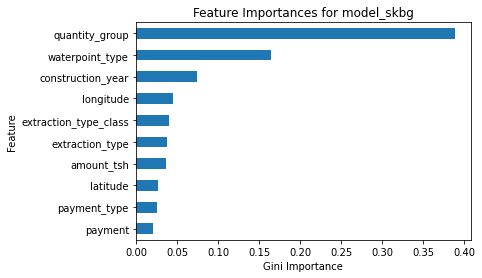

In [19]:
importances = model_skgb.named_steps['gradientboostingclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for model_skbg');

**Option 2:** Drop-column Importance

- Good, but computationally expensive because you have to train a model for each feature.

In [20]:
# STEP 1: Train a model with the feature whose importance we want to evaluate

feature = 'quantity_group'

model_w_feat = model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10,
                  random_state=42,
                  n_jobs=-1)
)

model_w_feat.fit(X_train, y_train)

print(f'Validation accuracy with "{feature}" included:', model_w_feat.score(X_val, y_val))

Validation accuracy with "quantity_group" included: 0.7554713804713805


In [21]:
# STEP 2: Train a model WITHOUT the feature we want to evaluate
model_wo_feat = model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10,
                  random_state=42,
                  n_jobs=-1)
)

model_wo_feat.fit(X_train.drop(columns=feature), y_train)

print(f'Validation accuracy without "{feature}" included:', 
      model_wo_feat.score(X_val.drop(columns=feature), y_val))

Validation accuracy without "quantity_group" included: 0.7198653198653199


**Option 3:** Permutation Importance

By hand

In [36]:
# "By hand"
# Feature: `quantity_group`

# STEP 1: Train model on whole dataset
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10,
                  random_state=42,
                  n_jobs=10)
)

model_xgb.fit(X_train, y_train);

# STEP 2: Evaluate using the validation set
print('Validation Accuracy', model_xgb.score(X_val, y_val))

# STEP 3: In our VALIDATION set, permute the feature we want to evaluate
X_val_perm = X_val.copy()
X_val_perm[feature] = permutation(X_val_perm[feature])

# STEP 4: Caluculate the performance metric with the permuted data
print(f'Validation Accuracy with "{feature}" permuted:', model_xgb.score(X_val_perm, y_val))

Validation Accuracy 0.7554713804713805
Validation Accuracy with "quantity_group" permuted: 0.6583333333333333


Using `sklearn`

In [37]:
perm_imp = permutation_importance(
    model_xgb,
    X_val, # Always use your VALIDATION set
    y_val, 
    n_jobs=10,
    random_state=42
)

In [40]:
# Put results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

In [41]:
df

,importances_mean,importances_std
source_type,0.000000,0.000000
quality_group,0.000000,0.000000
num_private,0.000000,0.000000
payment_type,0.000000,0.000000
management_group,0.000000,0.000000
recorded_by,0.000000,0.000000
waterpoint_type_group,0.000438,0.000098
water_quality,0.000471,0.000203
public_meeting,0.000741,0.000263
source_class,0.001481,0.000230


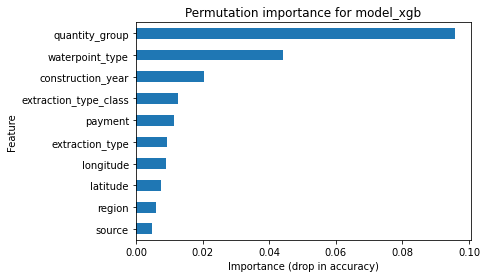

In [42]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');